In [601]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from tqdm import tqdm

In [651]:
num_anomalies = 5
num_regions = 5
figsize = (200, 1000)
horizontal_chunk = 10

In [652]:
convolution = []
for i in range(horizontal_chunk):
  if i < int(horizontal_chunk / 2):
    convolution.append([-1] * horizontal_chunk)
  else:
    convolution.append([1] * horizontal_chunk)

convolution = np.array(convolution)

In [623]:
def convolve(image, kernel):
  # We start off by defining some constants, which are required for this code
  kernelH, kernelW = kernel.shape
  imageH, imageW = image.shape
  h, w = imageH + 1 - kernelH, imageW + 1 - kernelW
  
  # filter1 creates an index system that calculates the sum of the x and y indices at each point
  # Shape of filter1 is h x kernelW
  filter1 = np.arange(kernelW) + np.arange(h)[:, np.newaxis]
  
  # intermediate is the stepped data, which has the shape h x kernelW x imageH
  intermediate = image[filter1]
  
  # transpose the inner dimensions of the intermediate so as to enact another filter
  # shape is now h x imageH x kernelW
  intermediate = np.transpose(intermediate, (0, 2, 1))
  
  # filter2 similarly creates an index system
  # Shape of filter2 is w * kernelH
  filter2 = np.arange(kernelH) + np.arange(w)[:, np.newaxis]
  
  # Apply filter2 on the inner data piecewise, resultant shape is h x w x kernelW x kernelH
  intermediate = intermediate[:, filter2]
  
  # transpose inwards again to get a resultant shape of h x w x kernelH x kernelW
  intermediate = np.transpose(intermediate, (0, 1, 3, 2))
  
  # piecewise multiplication with kernel
  product = intermediate * kernel
  
  # find the sum of each piecewise product, shape is now h x w
  convolved = np.abs(product.sum(axis = (2,3)))
  
  return convolved

In [624]:
horizontal_values = 1000 * np.random.uniform(3, 4, size = figsize[1])
for _ in range(1):  
  figsize = (200, 1000)
  fig = np.zeros(figsize)
  separated = False
  while(not separated):
    vertical_anomaly_indices = np.random.choice(range(horizontal_chunk, figsize[0] - horizontal_chunk), num_anomalies)
    vertical_anomaly_indices = np.sort(anomaly_indices)
    close = False
    for i in range(1, len(vertical_anomaly_indices)):
      if vertical_anomaly_indices[i] - vertical_anomaly_indices[i - 1] < 2 * horizontal_chunk:
        close = True
    separated = not close 

  horizontal_anomaly_indices = []
  for i, idx in enumerate(vertical_anomaly_indices):
    horizontal_changes = np.sort(np.random.choice(figsize[1], num_regions))
    horizontals = np.zeros(figsize[1])
    bit = 0
    for j in range(len(horizontals)):
      if j in horizontal_changes:
        bit = 1 - bit
      horizontals[j] = bit * horizontal_values[j]
    if i == 0:
      fig[0 : idx] = horizontals
      previous_horizontal = horizontals
      horizontal_changes = np.sort(np.random.choice(figsize[1], num_regions))
      horizontals = np.zeros(figsize[1])
      bit = 0
      for j in range(len(horizontals)):
        if j in horizontal_changes:
          bit = 1 - bit
        horizontals[j] = bit * horizontal_values[j]
      fig[idx : anomaly_indices[i + 1]] = horizontals
    elif i != len(anomaly_indices) - 1:
      fig[idx : anomaly_indices[i + 1]] = horizontals
    else:
      fig[idx : ] = horizontals
    
    horizontal_anomaly_indices.append(np.where((previous_horizontal == 0) != (horizontals == 0))[0])

    previous_horizontal = horizontals

  for i in range(len(fig)):
    if np.random.uniform() < .05:
      fig[i] = 1

In [625]:
vs = []
hs = []
for i in range(len(horizontal_anomaly_indices)):
    v = vertical_anomaly_indices[i]
    _hs = horizontal_anomaly_indices[i]
    for h in _hs:
        vs.append(v)
        hs.append(h)
true_anomaly_indices = [vs, hs]

In [626]:
convolved_fig = convolve(fig, np.array(convolution))

predicted_anomaly_indices = []
_predicted_anomaly_indices = np.where((convolved_fig / (np.max(fig))) > 20)
for i in range(len(_predicted_anomaly_indices)):
    predicted_anomaly_indices.append(_predicted_anomaly_indices[i] + len(convolution) / 2)

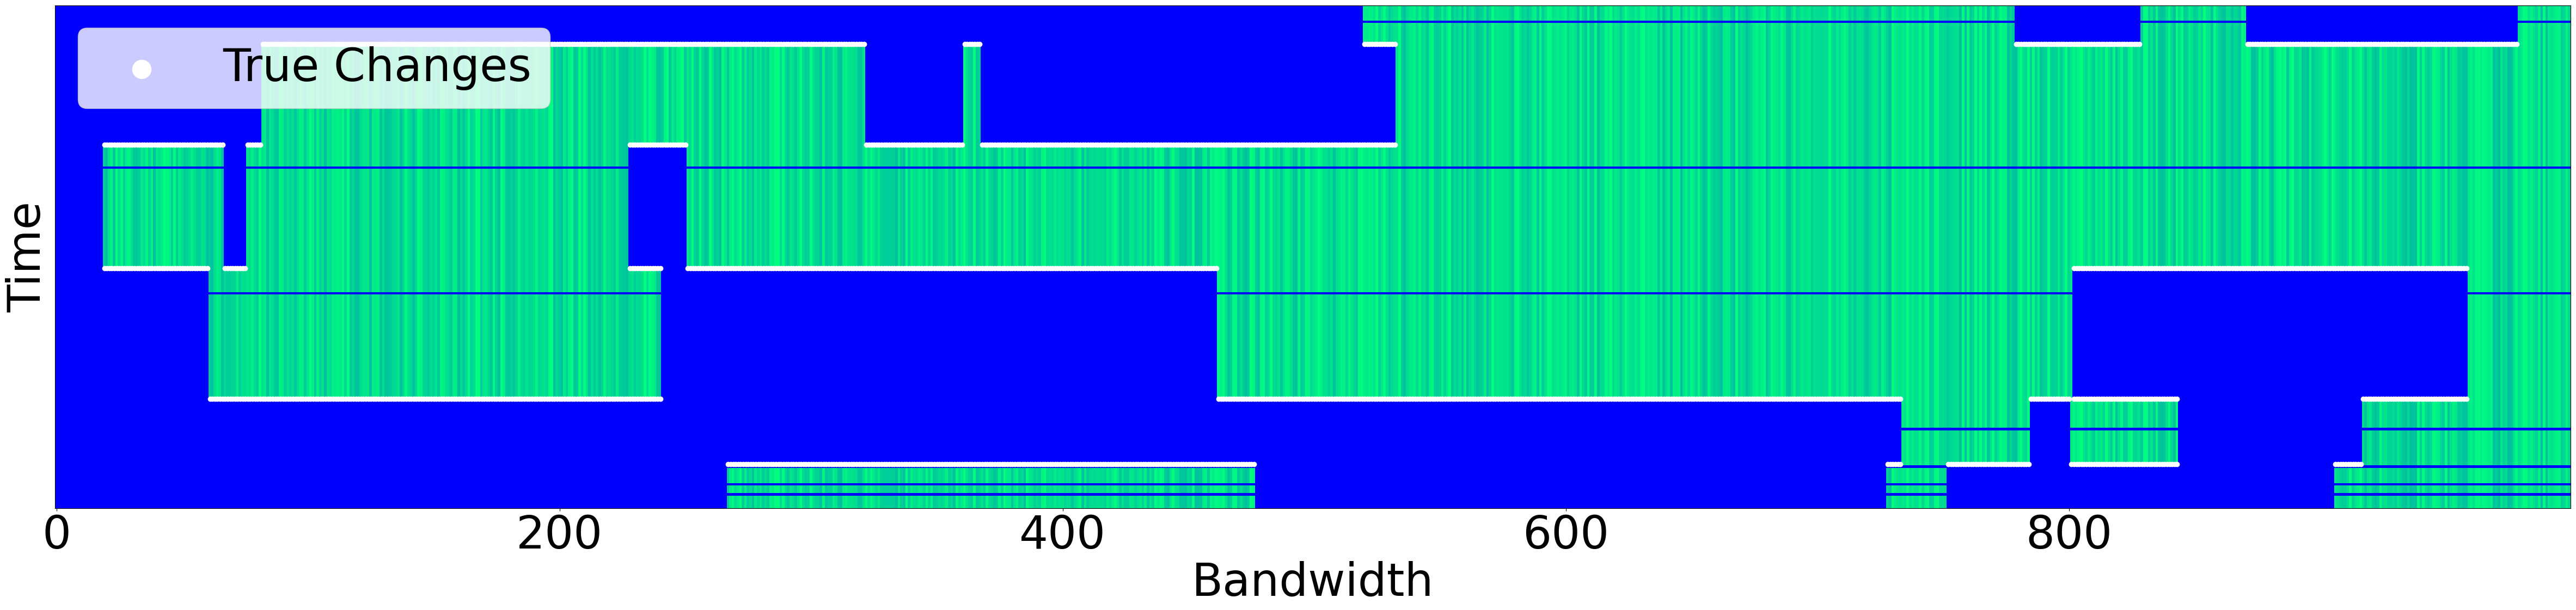

In [634]:
plt.figure(figsize = (60,12))
plt.imshow(fig, cmap = 'winter')
plt.scatter(true_anomaly_indices[1], true_anomaly_indices[0], c = 'white', label = "True Changes")
lgnd = plt.legend(loc = "upper left", fontsize = 60)
for handle in lgnd.legendHandles:
    handle.set_sizes([600])
plt.ylabel("Time", fontsize = 60)
plt.xlabel("Bandwidth", fontsize = 60)
plt.xticks(fontsize = 60)
plt.yticks([])
plt.show()

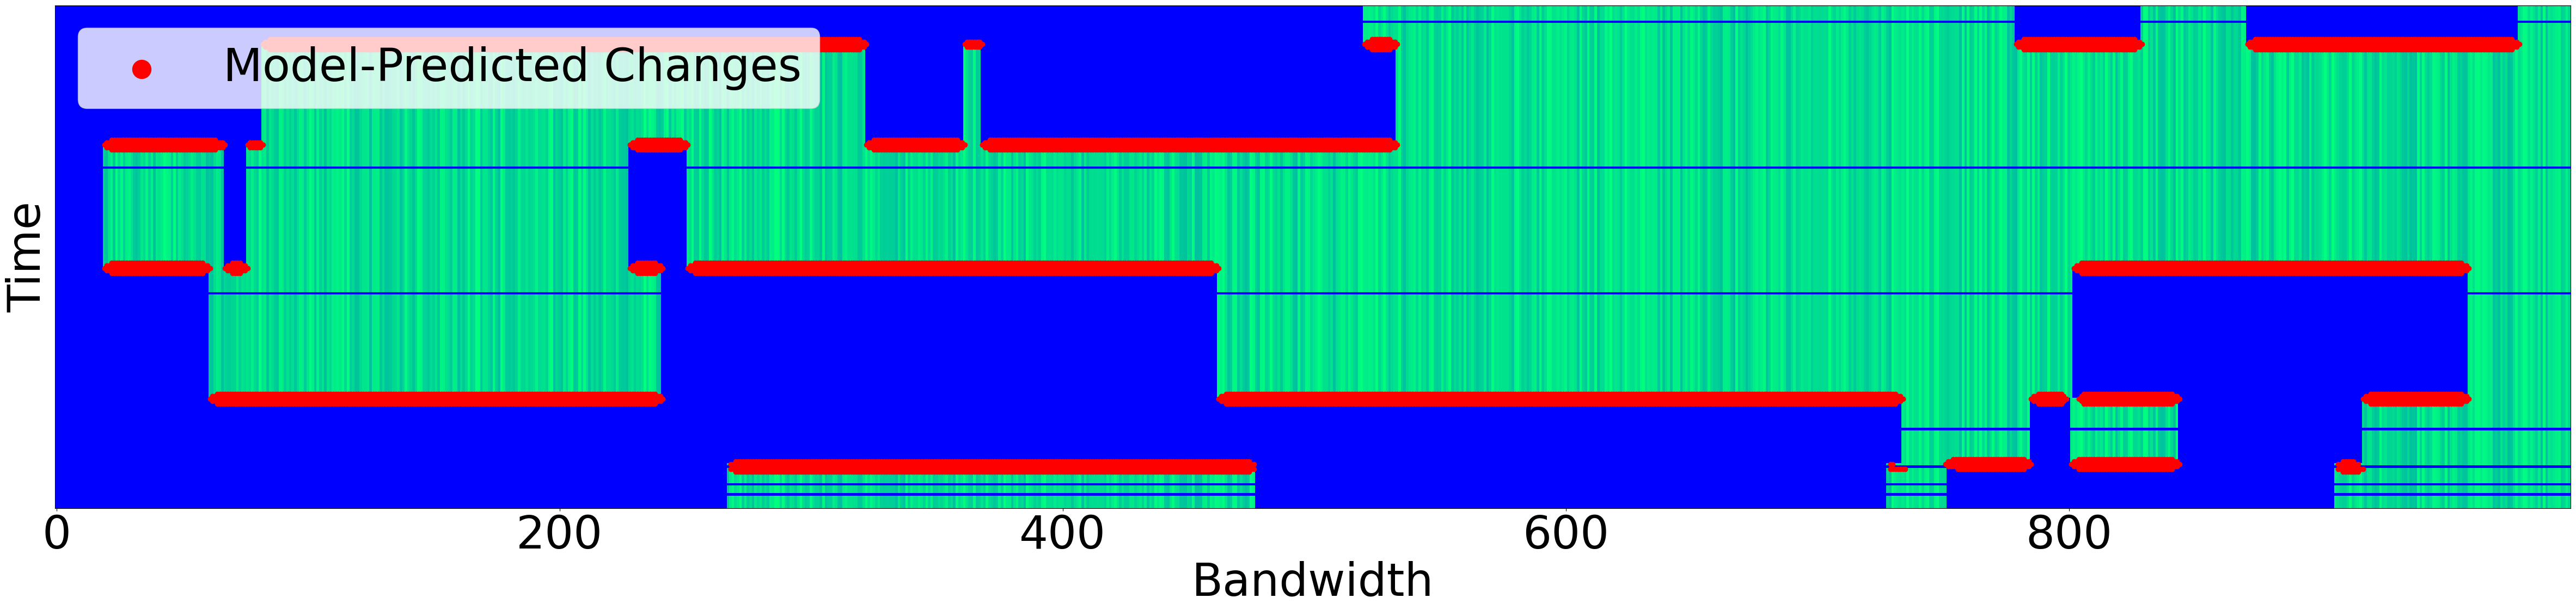

In [635]:
plt.figure(figsize = (60,12))
plt.imshow(fig, cmap = 'winter')
plt.scatter(predicted_anomaly_indices[1], predicted_anomaly_indices[0], c = 'r', label = "Model-Predicted Changes")
lgnd = plt.legend(loc = "upper left", fontsize = 60)
for handle in lgnd.legendHandles:
    handle.set_sizes([600])
plt.ylabel("Time", fontsize = 60)
plt.xlabel("Bandwidth", fontsize = 60)
plt.xticks(fontsize = 60)
plt.yticks([])
plt.show()

Text(0, 0.5, 'Power')

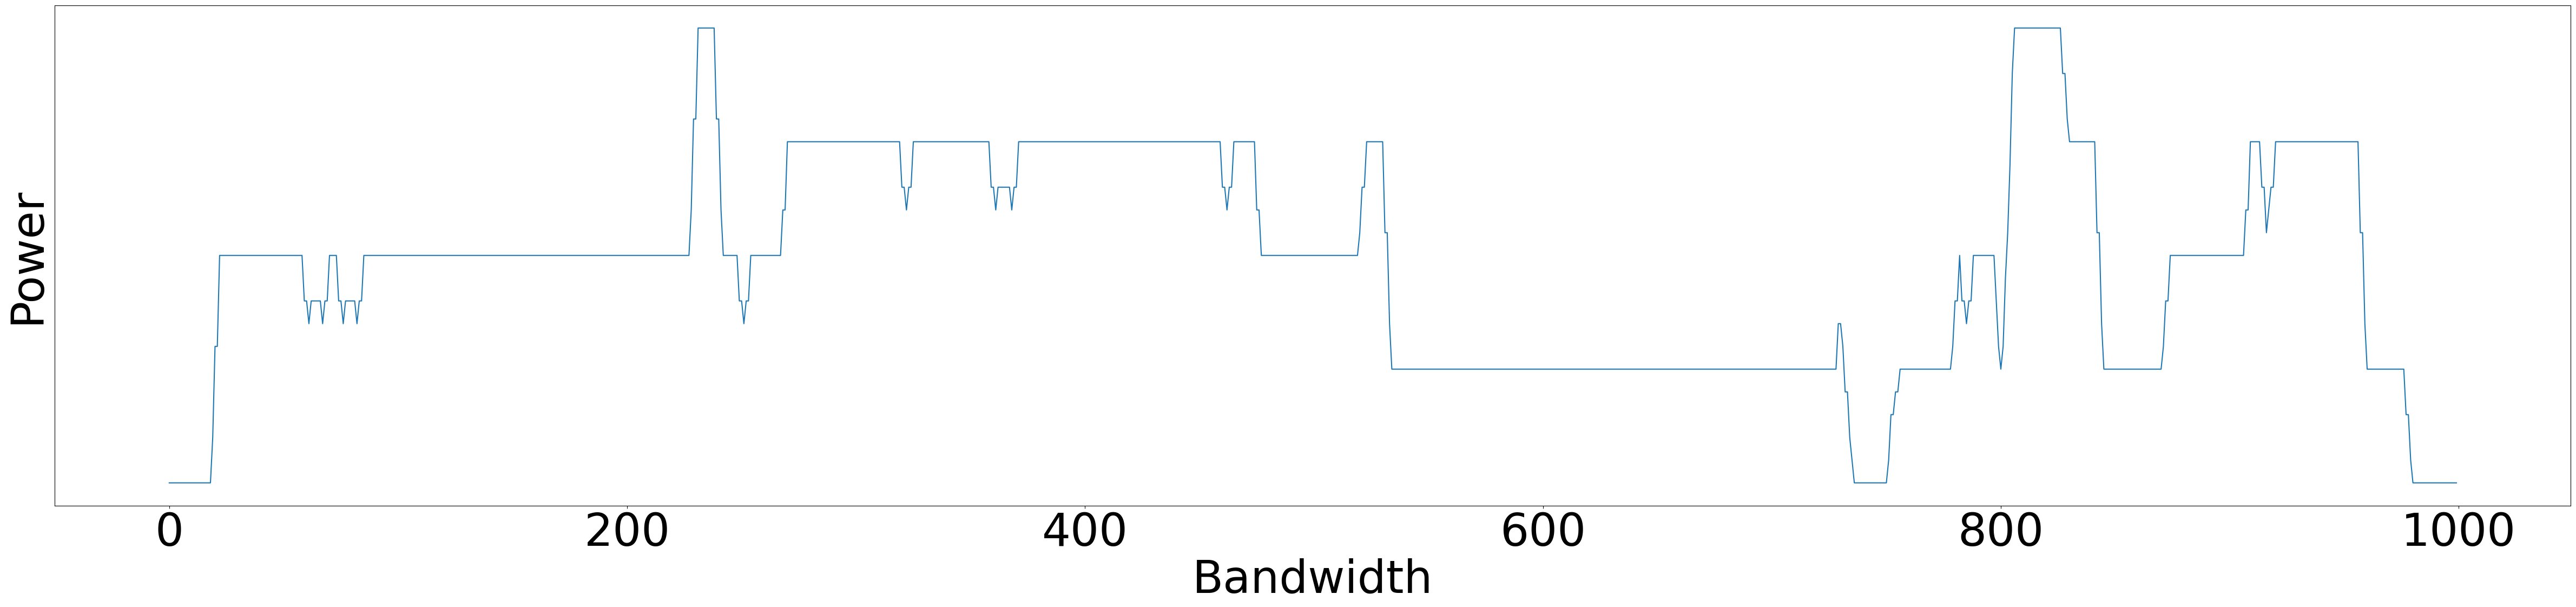

In [636]:
powers = np.zeros(figsize[1])
for i in predicted_anomaly_indices[1]:
    powers[int(i)] += 1
plt.figure(figsize = (60,12))
plt.plot(powers)
plt.xlabel("Bandwidth", fontsize = 60)
plt.xticks(fontsize = 60)
plt.yticks([])
plt.ylabel("Power", fontsize = 60)

In [637]:
predicted_positives_matched = np.zeros(len(predicted_anomaly_indices[0]))
truth_matched = np.zeros(len(true_anomaly_indices[0]))

for i in tqdm(range(len(predicted_positives_matched))):
    v_p = predicted_anomaly_indices[0][i]
    h_p = predicted_anomaly_indices[1][i]
    for j in range(len(truth_matched)):
        v_t = true_anomaly_indices[0][j]
        h_t = true_anomaly_indices[1][j]
        if np.abs(v_p - v_t) < 10 and np.abs(h_p - h_t) < 10:
            predicted_positives_matched[i] = 1
            truth_matched[j] = 1
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9611/9611 [00:18<00:00, 522.26it/s]


In [638]:
p = np.mean(predicted_positives_matched)
print("Precision: {}".format(p))
r = np.mean(truth_matched)
print("Recall: {}".format(r))
f1 = 2 * p * r / (p + r)
print("F1: {}".format(f1))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [639]:
precisions = []
recalls = []
fn_time_gaps = []
for _ in tqdm(range(100)):
  figsize = (200, 1000)
  fig = np.zeros(figsize)
  separated = False
  while(not separated):
    anomaly_indices = np.random.choice(range(horizontal_chunk, figsize[0] - horizontal_chunk), num_anomalies)
    anomaly_indices = np.sort(anomaly_indices)
    close = False
    for i in range(1, len(anomaly_indices)):
      if anomaly_indices[i] - anomaly_indices[i - 1] < 2 * horizontal_chunk:
        close = True
    separated = not close 
    
  horizontal_values = 1000 * np.random.uniform(3, 4, size = figsize[1])

  for i, idx in enumerate(anomaly_indices):
    horizontal_changes = np.sort(np.random.choice(figsize[1], num_regions))
    horizontals = np.zeros(figsize[1])
    bit = 0
    for j in range(len(horizontals)):
      if j in horizontal_changes:
        bit = 1 - bit
      horizontals[j] = bit * horizontal_values[j]
    if i == 0:
      fig[0 : idx] = horizontals
      horizontal_changes = np.sort(np.random.choice(figsize[1], num_regions))
      horizontals = np.zeros(figsize[1])
      bit = 0
      for j in range(len(horizontals)):
        if j in horizontal_changes:
          bit = 1 - bit
        horizontals[j] = bit * horizontal_values[j]
      fig[idx : anomaly_indices[i + 1]] = horizontals
    elif i != len(anomaly_indices) - 1:
      fig[idx : anomaly_indices[i + 1]] = horizontals
    else:
      fig[idx : ] = horizontals

  for i in range(len(fig)):
    if np.random.uniform() < .01:
      fig[i] = 1

  convolved_fig = convolve(fig, np.array(convolution))

  edge_indices = np.where(convolved_fig / (np.max(fig)) > 22)
  predicted_anomaly_indices = np.unique(edge_indices[0]) + len(convolution) / 2

  tp_count = 0
  fp_count = 0
  fn_count = 0
  for predicted_anomaly_index in predicted_anomaly_indices:
    tp = False
    for true_anomaly_index in anomaly_indices:
      if np.abs(predicted_anomaly_index - true_anomaly_index) < 10:
        tp = True
    if tp:
      tp_count += 1
    else:
      fp_count += 1

  fn_count = 0
  for true_anomaly_index in anomaly_indices:
    tp = False
    for predicted_anomaly_index in predicted_anomaly_indices:
      if np.abs(predicted_anomaly_index - true_anomaly_index) < 10:
        tp = True
    if not tp:
      fn_count += 1
      sorted_true_anomaly_indices = np.sort(anomaly_indices)
      i = np.where(sorted_true_anomaly_indices == true_anomaly_index)[0]
      fn_time_gaps.append(true_anomaly_index - sorted_true_anomaly_indices[i - 1])

  try:
    precision = tp_count / (tp_count + fp_count)
  except:
    precision = 0
  recall = tp_count / (tp_count + fn_count)

  precisions.append(precision)
  recalls.append(recall)

precision = np.mean(precisions)
recall = np.mean(recalls)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(2 * precision * recall / (precision + recall)))



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 12.10it/s]

Precision: 0.9992592592592593
Recall: 1.0
F1: 0.9996294924045943


In [640]:
convolution = []
for i in range(horizontal_chunk):
  if i < int(horizontal_chunk / 2):
    convolution.append([-1] * horizontal_chunk)
  else:
    convolution.append([1] * horizontal_chunk)

convolution = np.array(convolution).T

In [642]:
horizontal_values = 1000 * np.random.uniform(3, 4, size = figsize[1])
for _ in range(1):  
  figsize = (200, 1000)
  fig = np.zeros(figsize)
  separated = False
  while(not separated):
    vertical_anomaly_indices = np.random.choice(range(horizontal_chunk, figsize[0] - horizontal_chunk), num_anomalies)
    vertical_anomaly_indices = np.sort(anomaly_indices)
    close = False
    for i in range(1, len(vertical_anomaly_indices)):
      if vertical_anomaly_indices[i] - vertical_anomaly_indices[i - 1] < 2 * horizontal_chunk:
        close = True
    separated = not close 

  horizontal_anomaly_indices = []
  for i, idx in enumerate(vertical_anomaly_indices):
    horizontal_changes = np.sort(np.random.choice(figsize[1], num_regions))
    polars = np.random.uniform(1, 5, size = len(horizontal_changes))
    horizontals = np.zeros(figsize[1])
    bit = 0
    polar = polars[0]
    for j in range(len(horizontals)):
      if j in horizontal_changes:
        polar = polars[np.where(horizontal_changes == j)[0]]
        bit = 1 - bit
      horizontals[j] = bit * horizontal_values[j] * polar
    if i == 0:
      fig[0 : idx] = horizontals
      previous_horizontal = horizontals
      horizontal_changes = np.sort(np.random.choice(figsize[1], num_regions))
      horizontals = np.zeros(figsize[1])
      bit = 0
      for j in range(len(horizontals)):
        if j in horizontal_changes:
          bit = 1 - bit
        horizontals[j] = bit * horizontal_values[j]
      fig[idx : anomaly_indices[i + 1]] = horizontals
    elif i != len(anomaly_indices) - 1:
      fig[idx : anomaly_indices[i + 1]] = horizontals
    else:
      fig[idx : ] = horizontals
    
    horizontal_anomaly_indices.append(np.where((previous_horizontal == 0) != (horizontals == 0))[0])

    previous_horizontal = horizontals

  for i in range(len(fig)):
    if np.random.uniform() < .05:
      fig[i] = 1

In [643]:
convolved_fig = convolve(fig, np.array(convolution))

predicted_anomaly_indices = []
_predicted_anomaly_indices = np.where((convolved_fig / (np.max(fig))) > 40)
for i in range(len(_predicted_anomaly_indices)):
    predicted_anomaly_indices.append(_predicted_anomaly_indices[i] + len(convolution) / 2)

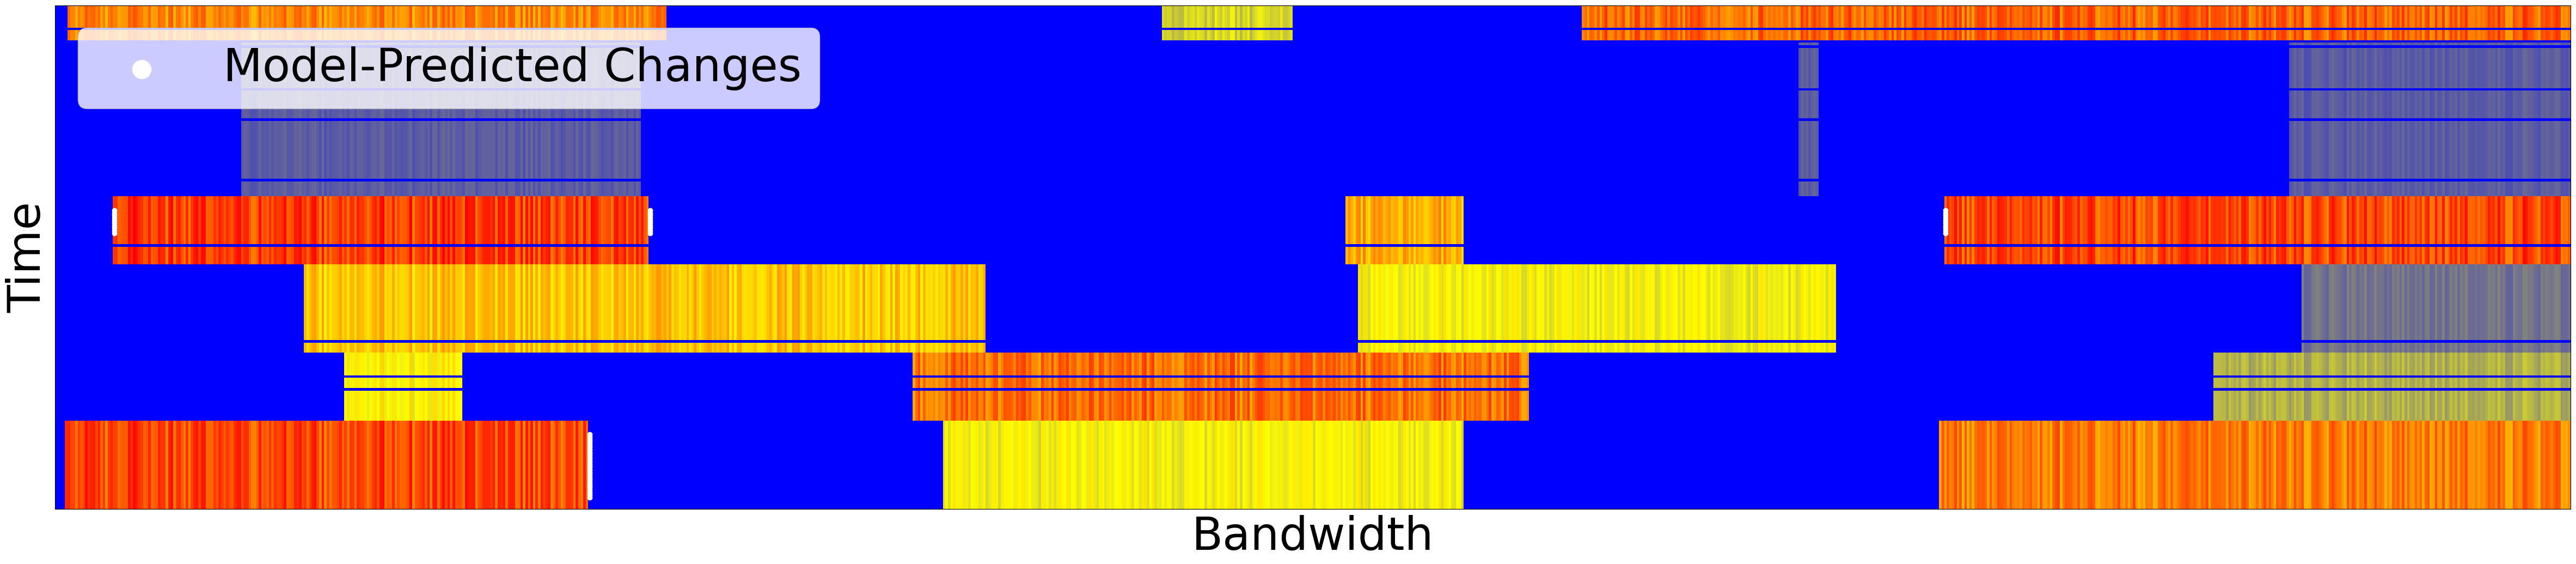

In [644]:
import matplotlib
plt.figure(figsize = (60,12))
plt.imshow(fig, cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["blue", "yellow","red"]))
plt.scatter(predicted_anomaly_indices[1], predicted_anomaly_indices[0], c = 'white', label = "Model-Predicted Changes")
lgnd = plt.legend(loc = "upper left", fontsize = 60)
for handle in lgnd.legendHandles:
    handle.set_sizes([600])
plt.ylabel("Time", fontsize = 60)
plt.xlabel("Bandwidth", fontsize = 60)
plt.xticks([])
plt.yticks([])
plt.show()

Text(0, 0.5, 'Power')

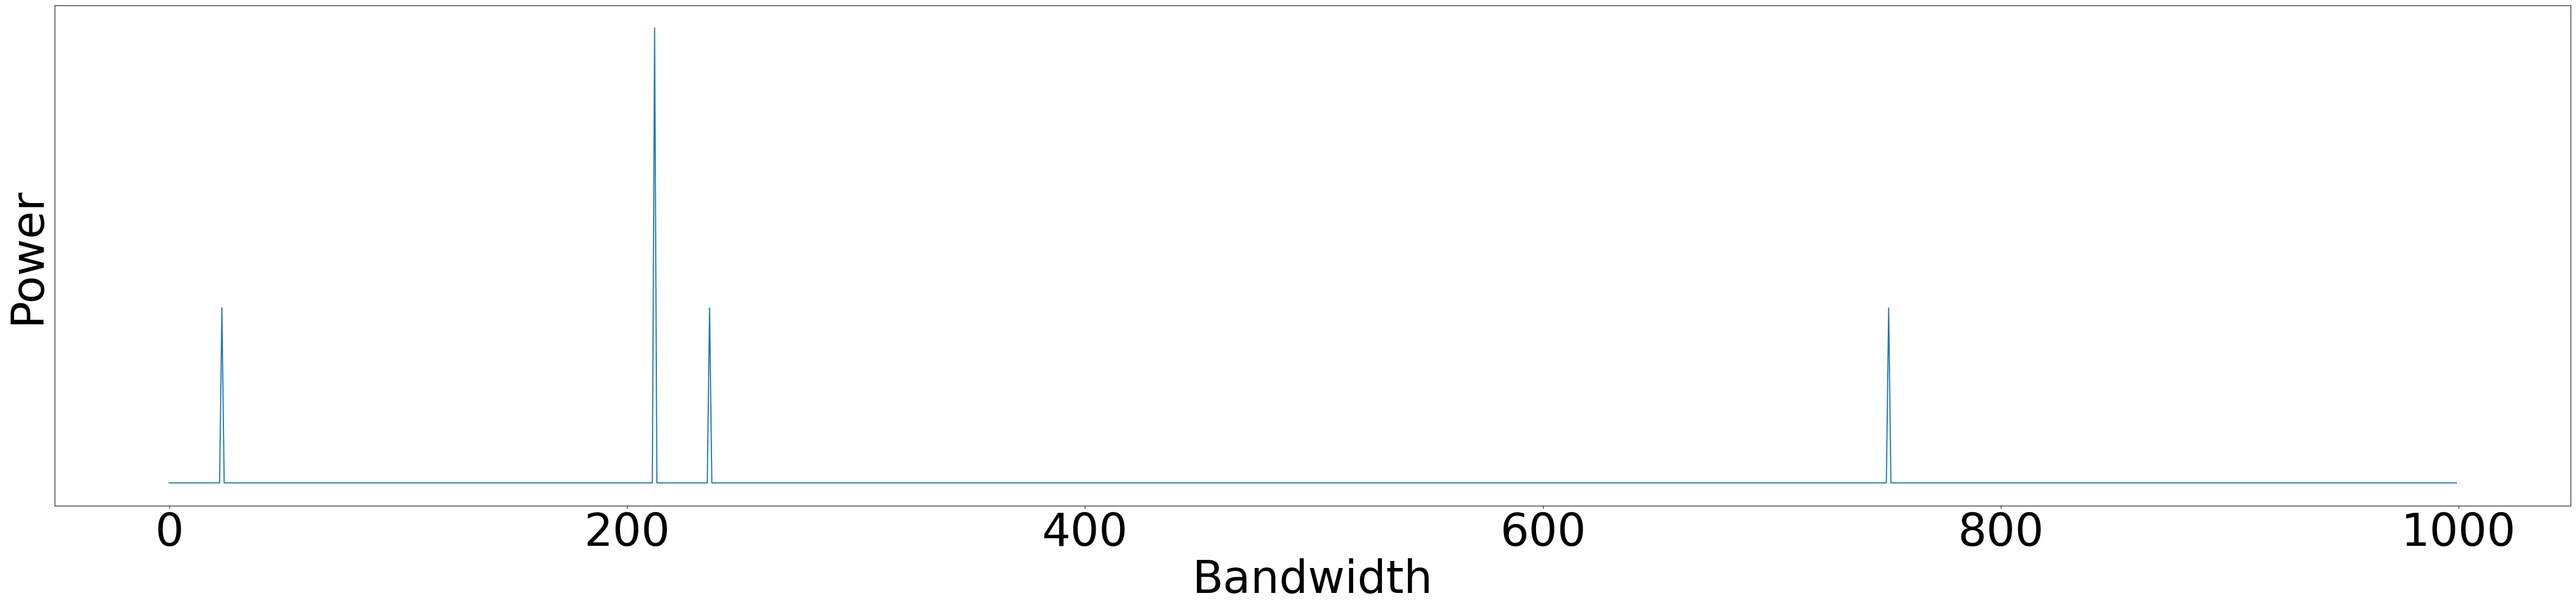

In [645]:
powers = np.zeros(figsize[1])
for i in predicted_anomaly_indices[1]:
    powers[int(i)] += 1
plt.figure(figsize = (60,12))
plt.plot(powers)
plt.xlabel("Bandwidth", fontsize = 60)
plt.xticks(fontsize = 60)
plt.yticks([])
plt.ylabel("Power", fontsize = 60)

In [674]:
convolution = []
for i in range(horizontal_chunk):
  if i < int(horizontal_chunk / 2):
    convolution.append([-1] * horizontal_chunk)
  else:
    convolution.append([1] * horizontal_chunk)

convolution = np.array(convolution)

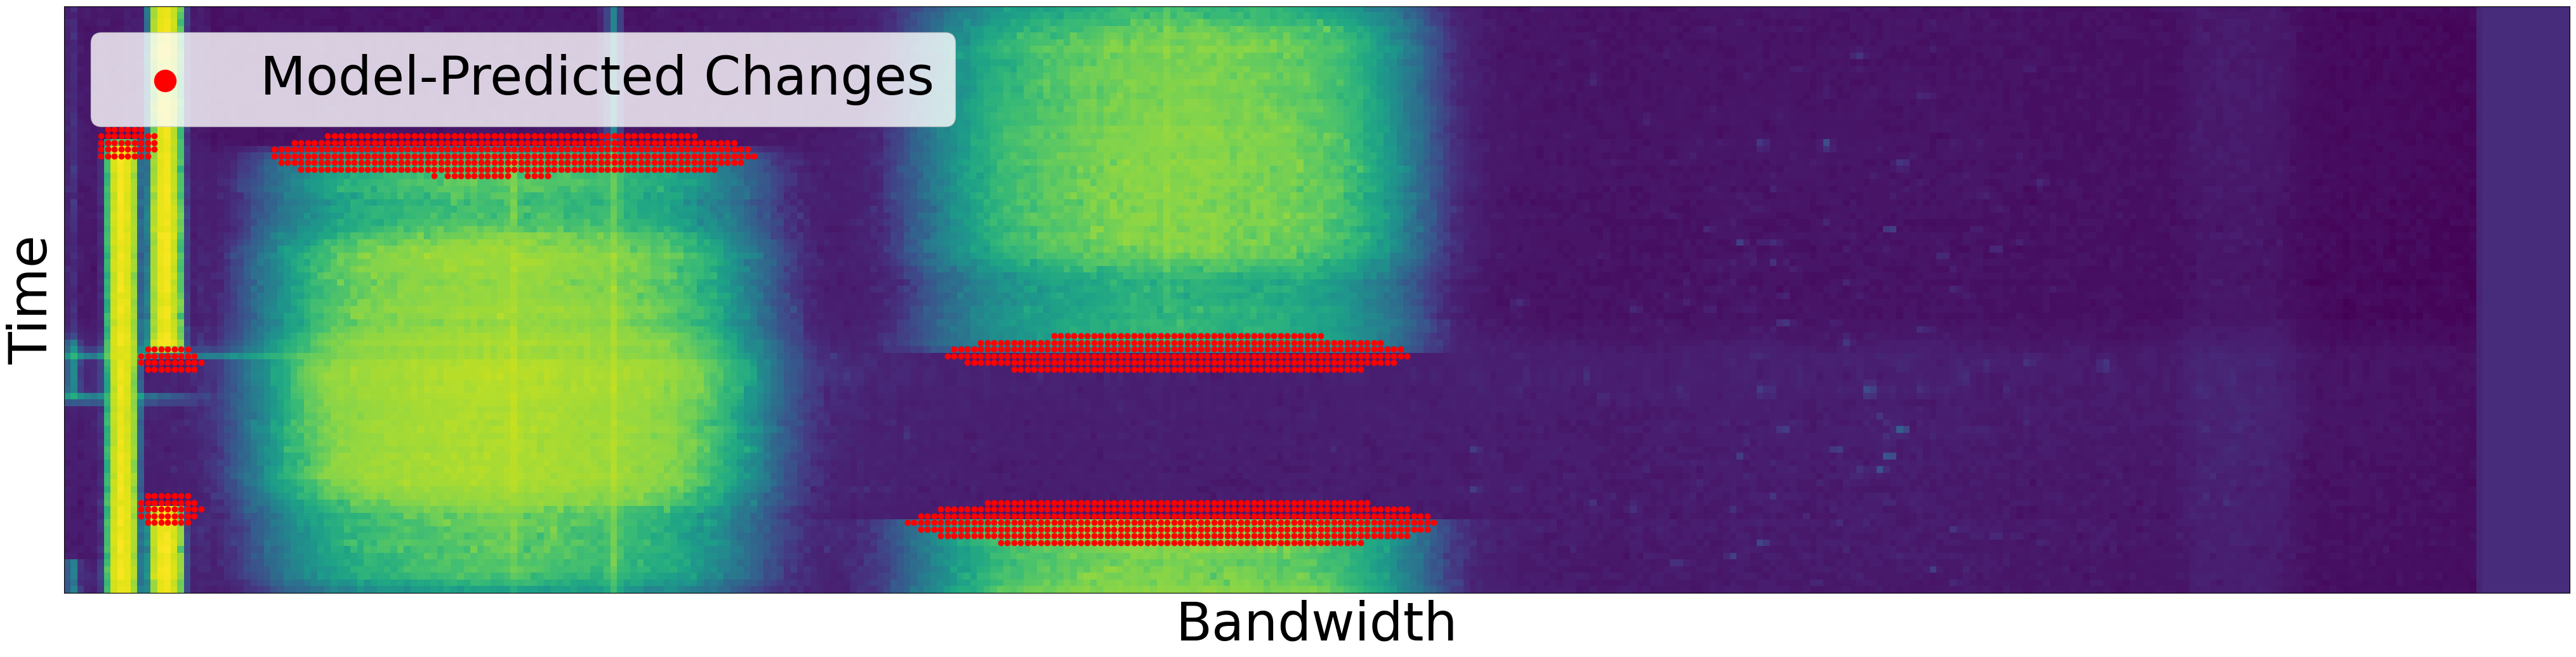

In [675]:
fig = plt.imread("example.png")[:, :, 0]
convolved_fig = convolve(fig, np.array(convolution))

predicted_anomaly_indices = []
_predicted_anomaly_indices = np.where((convolved_fig / (np.max(fig))) > 10)
for i in range(len(_predicted_anomaly_indices)):
    predicted_anomaly_indices.append(_predicted_anomaly_indices[i] + len(convolution) / 2)
    
import matplotlib
plt.figure(figsize = (60,12))
plt.imshow(fig)
plt.scatter(predicted_anomaly_indices[1], predicted_anomaly_indices[0], c = 'red', label = "Model-Predicted Changes")
lgnd = plt.legend(loc = "upper left", fontsize = 60)
for handle in lgnd.legendHandles:
    handle.set_sizes([600])
plt.ylabel("Time", fontsize = 60)
plt.xlabel("Bandwidth", fontsize = 60)
plt.xticks([])
plt.yticks([])
plt.show()